Import things to note when calculating PSD <br> 
Method to use (Welch) , Window size , overlap , etc... - Atm I have 4 second window with 50% overlap <br> 
See this website for some good info : https://sapienlabs.org/lab-talk/factors-that-impact-power-spectrum-density-estimation/#:~:text=The%20Welch%20method%20is%20another,pwelch()%20command%20in%20MATLAB. <br>
Scroll to bottom of the page for their summary <br>

In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts


/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [2]:
#Load the data and focus on one df specifically

t1 = time.time()

paths , class_list, sleep_night_list , sleep_type_list , participant_id_list = constants.generate_paths_and_info(blue_pebble = True)

path = paths[0]

with io.capture_output() as captured:
    data_epo = mne.read_epochs(path)
    sampling_freq =  data_epo.info['sfreq']  # find sampling frequency
    channels = data_epo.ch_names  # extract channel names
    data = data_epo._data * 1e6  # convert signal from V to uV
    
# Generate dataframe with channels as columns, samples ordered by time _____________________________________________________
channels = constants.channel_list
df_full = data_epo.to_data_frame()
df = df_full[channels].copy()

df

t2 = time.time()

t2-t1

0.7798693180084229

In [3]:
t1 = time.time()

#1.Generate the window indices 
window_indices = eeg_stat_ts.gen_window_indices(6, df , samp_freq = 256)
#2. Calculate bpw vals per window
bpw_per_win_df = eeg_stat_ts.gen_statistic_per_window(df , window_indices , stat = 'bpw')

t2 = time.time()

t2-t1

0.3325309753417969

<Figure size 640x480 with 0 Axes>

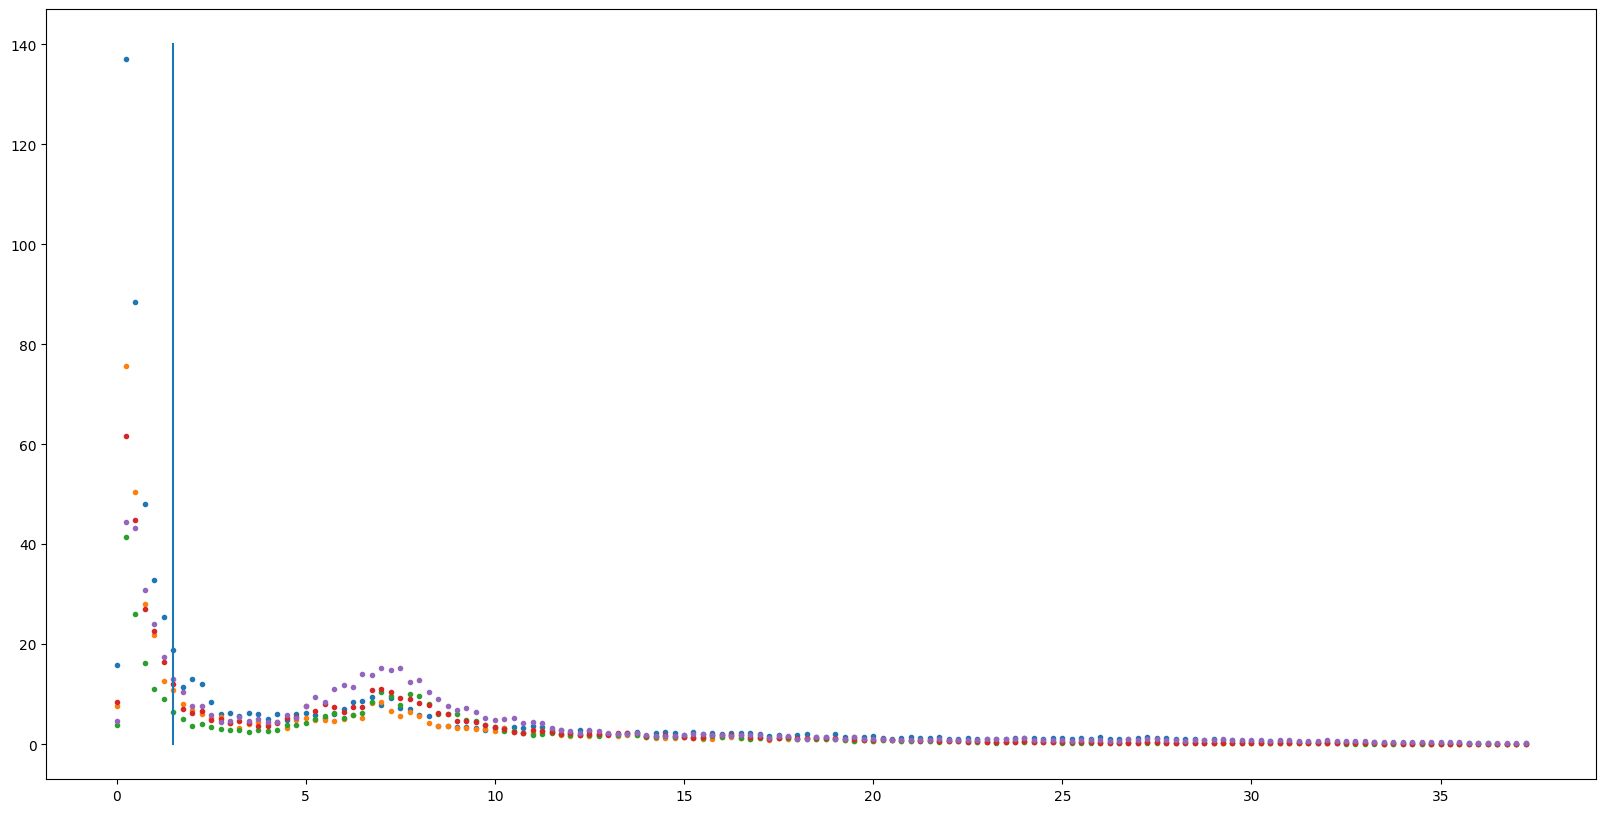

In [7]:
df_2 = df*2

win_s = 4
samp_freq = 256
channels = constants.channel_list

win = int(win_s * samp_freq) #Window for Welchs Periodagram
freqs, psd = welch(df_2.T.values , fs = samp_freq, nperseg=win, average='median')

fig = plt.figure()
fig = plt.figure(figsize=(20,10),dpi=100)
plt.scatter(freqs[:150] , psd[0, :][:150], marker=".")
plt.scatter(freqs[:150] , psd[20, :][:150] , marker=".")
plt.scatter(freqs[:150] , psd[30, :][:150] , marker=".")
plt.scatter(freqs[:150] , psd[40, :][:150] , marker=".")
plt.scatter(freqs[:150] , psd[50, :][:150] , marker=".")
plt.plot([1.5 ,1.5 ] , [0,140])

In [4]:
win_s = 4
samp_freq = 256
channels = constants.channel_list

win = int(win_s * samp_freq) #Window for Welchs Periodagram
freqs, psd = welch(df.T.values , fs = samp_freq, nperseg=win, average='median')

In [5]:
psd[: , index_num : ].shape

NameError: name 'index_num' is not defined

In [6]:
cut_off_freq = 4.5 #Keeps this frequency and higher
index_num = np.searchsorted(freqs, cut_off_freq , side = 'left') #Left gives you index of element that is equal to or less than what you input
freqs_new = freqs[index_num : ] 

In [ ]:
# plt.scatter(freqs[:150] , psd[0, :][:150], marker=".")
# plt.scatter(freqs[:150] , psd[20, :][:150] , marker=".")
# plt.scatter(freqs[:150] , psd[30, :][:150] , marker=".")
# plt.scatter(freqs[:150] , psd[40, :][:150] , marker=".")
# plt.scatter(freqs[:150] , psd[50, :][:150] , marker=".")

Text(0.5, 0, 'Frequency (Hz)')

<Figure size 640x480 with 0 Axes>

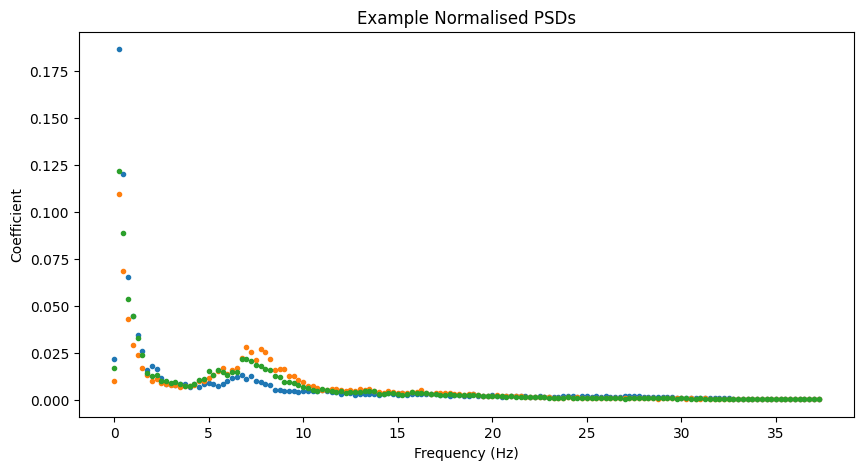

In [25]:
row_sums = np.sum(psd, axis=1, keepdims=True)
psd_normalised = np.divide(psd, row_sums)
psd_normalised

psd = psd_normalised


fig = plt.figure()
fig = plt.figure(figsize=(10,5),dpi=100)

plt.title('Example Normalised PSDs')

plt.scatter(freqs[:150] , psd[0, :][:150], marker = "." )
# plt.scatter(freqs[:150] , psd[20, :][:150] )
plt.scatter(freqs[:150] , psd[30, :][:150], marker=".")
plt.scatter(freqs[:150] , psd[40, :][:150],  marker="." )


plt.ylabel('Coefficient')
plt.xlabel('Frequency (Hz)')

# plt.scatter(freqs[:150] , psd[50, :][:150] )

### Testing Frequency Max Values Calculation

In [20]:
win = int(win_s * samp_freq) #Window for Welchs Periodagram
freqs, psd = welch(df.T.values , fs = samp_freq, nperseg=win, average='median')

In [23]:
#Keep cut off frequency and higher
cut_off_freq = 1.25
index_num = np.searchsorted(freqs, cut_off_freq , side = 'left') #Left gives you index of element that is equal to or less than what you input
freqs = freqs[index_num : ] 
psd = psd[: , index_num : ]

In [25]:
row_sums = np.sum(psd, axis=1, keepdims=True)
psd_normalised = np.divide(psd, row_sums)

In [26]:
channel_psd_normalised = pd.DataFrame(psd_normalised, index=channels , columns=freqs) #convert psd array into dataframe

In [27]:
channel_psd_normalised

,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,...,125.75,126.00,126.25,126.50,126.75,127.00,127.25,127.50,127.75,128.00
Fp1,0.061669,0.045708,0.027904,0.031676,0.029021,0.020725,0.014646,0.014928,0.013482,0.014922,...,3.992336e-13,2.200410e-13,1.060867e-13,2.784583e-14,4.232575e-14,2.046577e-13,3.075293e-13,4.403678e-13,5.912491e-13,2.025677e-13
Fpz,0.063410,0.048962,0.028507,0.027280,0.021933,0.016305,0.013501,0.012172,0.013429,0.014724,...,2.632740e-13,1.710172e-13,5.531129e-14,1.736677e-14,3.505368e-14,1.461329e-13,2.653709e-13,3.646180e-13,6.852331e-13,4.160936e-13
Fp2,0.055746,0.050399,0.032626,0.030267,0.022386,0.017107,0.014556,0.015445,0.014212,0.014642,...,3.058477e-13,2.139419e-13,6.433818e-14,2.023466e-14,4.693276e-14,2.465312e-13,3.523025e-13,5.215782e-13,7.952187e-13,4.638020e-13
F1,0.026012,0.025549,0.016471,0.016647,0.015167,0.014921,0.013543,0.011936,0.012358,0.010036,...,1.130120e-13,5.724775e-14,1.796520e-14,5.835940e-15,1.388722e-14,3.871189e-14,8.744164e-14,1.228588e-13,3.678843e-13,4.502235e-13
Fz,0.031618,0.022115,0.018062,0.012782,0.016164,0.015773,0.013081,0.012493,0.012074,0.011473,...,1.004970e-13,6.848764e-14,2.105232e-14,5.019848e-15,1.298664e-14,4.721593e-14,9.638943e-14,1.688083e-13,2.469500e-13,1.424808e-13
F2,0.040846,0.025538,0.016850,0.013815,0.014615,0.011644,0.011734,0.010572,0.011168,0.011112,...,9.565733e-14,6.380062e-14,2.901520e-14,7.040554e-15,1.721964e-14,5.341614e-14,1.049128e-13,1.439128e-13,6.915666e-13,9.664036e-13
AF7,0.060805,0.043780,0.031724,0.025167,0.028143,0.019557,0.014647,0.014490,0.014225,0.014231,...,2.569536e-13,1.607212e-13,5.211661e-14,1.402671e-14,4.033493e-14,1.132660e-13,2.340515e-13,2.982637e-13,5.867137e-13,3.866799e-13
F7,0.051354,0.043838,0.033943,0.025911,0.029442,0.017838,0.015152,0.013647,0.014391,0.013789,...,4.242205e-13,3.201188e-13,9.184054e-14,2.819703e-14,4.483864e-14,1.990540e-13,3.636620e-13,6.212005e-13,1.496088e-12,7.773109e-13
F5,0.050647,0.033020,0.021605,0.020225,0.019736,0.013541,0.011528,0.009948,0.012353,0.011607,...,3.160025e-13,1.513979e-13,5.690506e-14,1.773767e-14,4.216260e-14,1.100798e-13,1.970331e-13,3.022675e-13,9.982205e-13,6.343245e-13
F3,0.046385,0.027215,0.020486,0.016221,0.014810,0.011909,0.011480,0.010189,0.010534,0.010104,...,1.261145e-13,5.997684e-14,3.143834e-14,7.817047e-15,1.560675e-14,5.581773e-14,1.246326e-13,1.578332e-13,2.324420e-13,1.356509e-13


In [37]:
channel_to_region_dict = {}
for channel in constants.channel_list:
    for region in constants.regions:
        if channel in constants.region_to_channel_dict[region]:
            channel_to_region_dict[channel] = region

In [28]:
#From the normalised PSD Dataframe, caluclate the max power values and corresponding frequency values
# Create a new DataFrame with maximum, second-highest, third-highest, and fourth-highest values
# along with their corresponding column names

sorted_values = channel_psd_normalised.apply(lambda row: sorted(zip(row, row.index), reverse=True), axis=1)

max_values = sorted_values.apply(lambda row: row[0][0])
max_columns = sorted_values.apply(lambda row: row[0][1])

second_max_values = sorted_values.apply(lambda row: row[1][0])
second_max_columns = sorted_values.apply(lambda row: row[1][1])

third_max_values = sorted_values.apply(lambda row: row[2][0])
third_max_columns = sorted_values.apply(lambda row: row[2][1])

fourth_max_values = sorted_values.apply(lambda row: row[3][0])
fourth_max_columns = sorted_values.apply(lambda row: row[3][1])

new_df = pd.DataFrame({'First_Max_Value': max_values, 'First_Max_Freq': max_columns,
                        'Second_Max_Value': second_max_values, 'Second_Max_Freq': second_max_columns,
                        'Third_Max_Value': third_max_values, 'Third_Max_Freq': third_max_columns,
                        'Fourth_Max_Value': fourth_max_values, 'Fourth_Max_Freq': fourth_max_columns},
                       index=channel_psd_normalised.index)

In [38]:
new_df['Region'] = [channel_to_region_dict[channel] for channel in new_df.index]

In [41]:
for region in constants.regions:
    display( new_df[new_df['Region'] == region] )

,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
Fp1,0.061669,1.25,0.045708,1.5,0.031676,2.00,0.029021,2.25,Prefrontal
Fpz,0.063410,1.25,0.048962,1.5,0.028507,1.75,0.027280,2.00,Prefrontal
Fp2,0.055746,1.25,0.050399,1.5,0.032626,1.75,0.030267,2.00,Prefrontal


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
F1,0.042436,7.00,0.033404,6.75,0.031814,7.25,0.029880,6.50,Frontal
Fz,0.041169,7.00,0.034326,6.75,0.031618,1.25,0.030804,7.25,Frontal
F2,0.040846,1.25,0.035254,6.75,0.033687,7.00,0.029183,7.25,Frontal


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
AF7,0.060805,1.25,0.043780,1.50,0.031724,1.75,0.028143,2.25,Left Frontal
F7,0.051354,1.25,0.043838,1.50,0.033943,1.75,0.029442,2.25,Left Frontal
F5,0.050647,1.25,0.033020,1.50,0.029735,7.25,0.026425,6.50,Left Frontal
F3,0.046385,1.25,0.031283,7.25,0.030190,7.00,0.029864,6.50,Left Frontal


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
AF8,0.059072,1.25,0.039693,1.5,0.028391,1.75,0.024314,6.75,Right Frontal
F8,0.050705,1.25,0.034163,1.5,0.033349,6.75,0.028509,1.75,Right Frontal
F6,0.044883,1.25,0.036767,1.5,0.027486,6.75,0.027353,7.25,Right Frontal
F4,0.042823,1.25,0.035363,1.5,0.031188,6.75,0.028229,7.25,Right Frontal


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
FCz,0.035236,7.00,0.031485,7.25,0.029644,1.25,0.029627,7.50,Central
FC1,0.037318,7.00,0.035961,7.50,0.034744,7.25,0.031377,6.50,Central
FC2,0.031599,1.50,0.031325,7.00,0.031049,1.25,0.030526,7.50,Central
Cz,0.040181,1.25,0.032210,1.50,0.029932,7.00,0.028196,1.75,Central
C1,0.040253,1.25,0.033595,1.50,0.031310,7.00,0.029118,7.25,Central
C2,0.046658,1.25,0.037319,1.50,0.027720,1.75,0.027243,7.25,Central
CP1,0.045568,1.25,0.038988,1.50,0.030280,7.00,0.029537,6.75,Central
CP2,0.054564,1.25,0.044720,1.50,0.034714,7.00,0.034054,6.75,Central


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
FC5,0.048419,1.25,0.034551,1.50,0.030534,7.00,0.024280,7.25,Left Central
FC3,0.036912,7.25,0.036865,7.00,0.031066,6.75,0.030820,7.50,Left Central
C5,0.042665,1.25,0.036113,7.50,0.035614,7.00,0.030973,7.75,Left Central
C3,0.034603,1.50,0.032459,1.25,0.028880,7.75,0.027713,7.50,Left Central
CP5,0.033260,7.00,0.033047,7.50,0.032811,7.25,0.032422,7.75,Left Central
CP3,0.035021,1.25,0.031008,1.50,0.028720,7.25,0.027497,7.00,Left Central


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
FC6,0.048194,1.25,0.040269,1.50,0.032545,7.25,0.031179,7.00,Right Central
FC4,0.035490,1.25,0.030495,7.50,0.030255,1.50,0.029084,6.75,Right Central
C6,0.037631,7.00,0.036032,7.75,0.034541,7.25,0.034378,8.00,Right Central
C4,0.035943,1.25,0.035143,7.00,0.029415,7.25,0.025686,7.75,Right Central
CP6,0.036967,7.25,0.035872,7.00,0.032485,1.25,0.031789,7.50,Right Central
CP4,0.034897,1.25,0.032867,1.50,0.030931,7.00,0.026556,7.75,Right Central


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
TP7,0.047977,7.00,0.039191,6.75,0.039085,7.25,0.037555,7.50,Left Temporal
T7,0.039883,7.25,0.039814,7.00,0.038145,1.25,0.034814,6.50,Left Temporal
FT7,0.047735,1.25,0.036908,1.50,0.035883,7.00,0.029723,6.75,Left Temporal
FT9,0.047699,1.25,0.041888,7.00,0.039925,1.50,0.034829,6.75,Left Temporal


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
TP8,0.045253,7.00,0.044243,7.25,0.043052,6.75,0.039657,7.50,Right Temporal
T8,0.042527,1.25,0.038385,7.00,0.037642,7.25,0.035278,1.50,Right Temporal
FT8,0.048387,1.25,0.035126,1.50,0.032132,7.00,0.032014,6.75,Right Temporal
FT10,0.051870,1.25,0.033053,7.00,0.032278,1.50,0.032158,7.25,Right Temporal


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
P1,0.060854,1.25,0.037062,1.5,0.030825,7.00,0.029511,6.75,Parietal
P2,0.061275,1.25,0.042277,1.5,0.028823,1.75,0.028730,7.00,Parietal
Pz,0.071489,1.25,0.047617,1.5,0.032289,7.00,0.027234,6.75,Parietal


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
P3,0.042796,1.25,0.031960,7.25,0.031685,7.00,0.030034,1.50,Left Parietal
P5,0.037271,7.25,0.035150,6.75,0.034333,7.00,0.031834,1.25,Left Parietal
P7,0.044511,6.75,0.042409,7.00,0.041119,7.25,0.037263,7.50,Left Parietal
PO7,0.039043,1.25,0.038380,7.25,0.038217,6.75,0.036652,7.00,Left Parietal


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
P4,0.046021,1.25,0.038120,1.50,0.028716,6.75,0.027376,7.50,Right Parietal
P6,0.037137,1.25,0.032543,7.50,0.032441,7.00,0.031938,7.25,Right Parietal
P8,0.043537,1.25,0.040627,6.75,0.040587,7.25,0.039019,7.00,Right Parietal
PO8,0.049526,1.25,0.038386,1.50,0.036263,6.75,0.032841,7.00,Right Parietal


,First_Max_Value,First_Max_Freq,Second_Max_Value,Second_Max_Freq,Third_Max_Value,Third_Max_Freq,Fourth_Max_Value,Fourth_Max_Freq,Region
POz,0.066138,1.25,0.041328,1.50,0.026423,7.25,0.025766,6.75,Occipital
O1,0.041399,1.25,0.032749,6.75,0.031745,1.50,0.029977,7.25,Occipital
O2,0.043546,1.25,0.040622,1.50,0.029598,6.75,0.027304,7.00,Occipital
Oz,0.041705,1.25,0.036269,1.50,0.029113,7.00,0.027487,6.75,Occipital
